# SENSE reconstruction 
###### Author: Zimu Huo
###### Date: 02.2022

# Formulation
The image is acquired with multiple receiver coils denoted by sensitivity encoding operator S. The Fourier encoding is represented as a discrete Fourier encoding matrix F, where each row captures the positive or negative frequency attributes within a signal.

\begin{equation}
\begin{aligned}
\min_{x} \quad &  \quad & ||DFSx - y||^2  + \lambda ||x||_2
\end{aligned}
\end{equation}


In this case, we're able to tackle the problem in a localized manner, as we have the information about the aliased pixels, the overlapping pixels, and the coil sensitivity weights. With this knowledge, we can formulate and solve for each individual pixel.

-------------------------------------------------------------------------
References
    
    [1] 
    Author: Klaas P. Pruessmann et al. 
    Title: SENSE: Sensitivity Encoding for Fast MRI
    Link: https://pubmed.ncbi.nlm.nih.gov/10542355/

In [22]:
import sys
sys.path.insert(1, '../')
import matplotlib.pyplot as plt
import util.coil as coil 
import util.phantom as phantom
import numpy as np
import util.mask as undersample
from util.fft import *
# from util.SENSE import *
from util.sense import * 
import util.simulator as simulator
import util.mask as undersample
from util.fft import *
import util.simulator as simulate
from util.grappa import *
import util.phantom as phantom

In [23]:
data = phantom.brain(256, 4)
rawImage = ifft2c(data)
acs = simulate.acs(data, (32, 32))

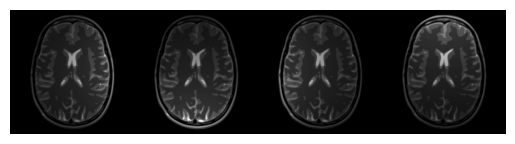

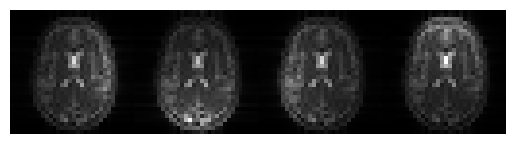

In [24]:
# fully sampled data
show(rawImage)
# low resolution fully sampled center of k-space
show(ifft2c(acs))

<div style="font-size: 1.2em;">
In a conventional MRI acquisition, multiple RF receivers are utilized to capture the image data, with each receiver positioned at a distinct spatial location relative to the image. Consequently, certain regions of the image will exhibit greater sensitivity to particular receivers, implying that each coil provides a somewhat distinct perspective of the imaging subject. By treating this unique perspective, or spatial sensitivity modulation, as an additional layer of spatial encoding - similar to the phase encoding and frequency encoding steps - a greater amount of information can be extracted and utilized in reconstructing the undersampled image. 
</div>

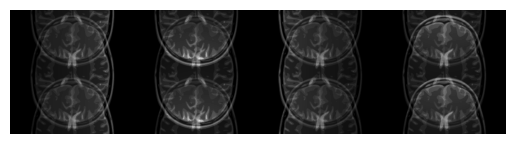

In [25]:
dataR = np.zeros(data.shape, dtype = complex)
R = 2
dataR[::R] = data[::R]
show(ifft2c(dataR))

In [26]:
from tqdm.notebook import tqdm
import util.coil as coil 
from util.zpad import * 
from util.fft import * 
def sense(dataR, acs, lamda = 1E-4):
    mask = np.where(dataR[:,0,0] == 0, 0, 1).flatten()
    R = int(np.ceil(mask.shape[0]/np.sum(mask)))
    [ny, nx, nc] = dataR.shape
    images = ifft2c(dataR)
    readny = int(ny/R)
    pat = ifft2c(zpad(acs, (ny, nx), (0,1)))
    coilmaps = coil.walsh_cmap(pat) 
    coilmaps = coilmaps / np.max(coil.rsos(coilmaps))
    recon = np.zeros([ny,nx], dtype = complex)
    for x in (range(nx)):
        for y in range(readny):
            yidx = np.arange(y,ny,readny)
            S = coilmaps[yidx,x,:]
            STS = S.T @ S     
            #M = np.linalg.inv(STS+np.eye(STS.shape[0])*lamda*np.linalg.norm(STS)/STS.shape[0])@S.T 
            M = np.linalg.pinv(STS)@S.T 
            recon[yidx,x] = M.T@images[y,x,:]
    return recon

In [27]:
recon = sense(dataR, acs)

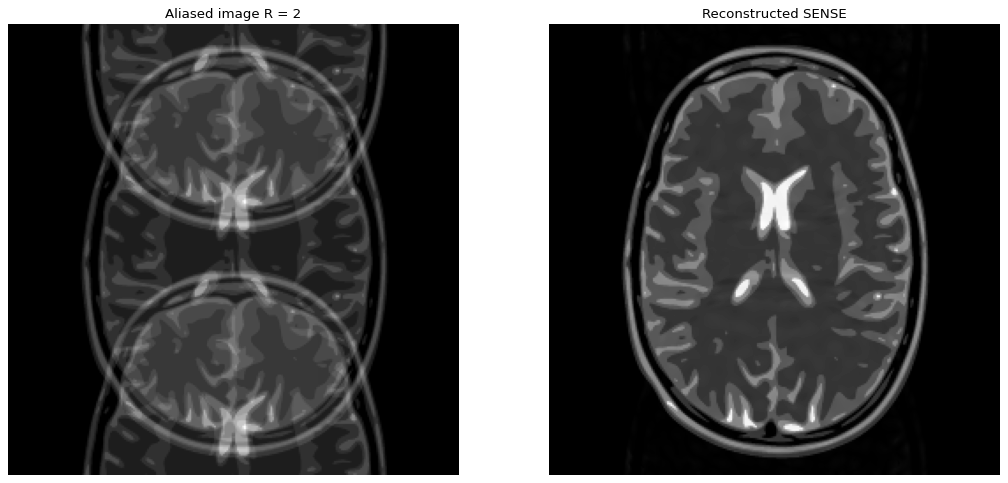

In [28]:
plt.figure(figsize=(16, 12), dpi=80)
plt.subplot(121)
plt.imshow(np.abs(coil.rsos(ifft2c(dataR))), cmap='gray')
plt.title("Aliased image R = "+str(R))
plt.axis("off")
plt.subplot(122)
plt.imshow(np.abs(recon), cmap='gray')
plt.title("Reconstructed SENSE")
plt.axis("off")
plt.show()